### KNN REGRESSION

The following Notebook was created to learn how a kNN regression algorithm is built and evaluated. Throughout the Notebook I have explained each step and evaluated any output my model has produced. Everything in this Notebook is my own work.

I will be looking into what factors that affect happiness in OECD countries. I will be using a kNN regression model to find correlations between the response variable 'Life Ladder' and our WHRData dataset predictors.

\- Written by Leonard Phillips

In [1]:
import pandas as pd

This model will be built using the 'WHRData.csv' data set provided by The World Bank.

In [2]:
WHRData = pd.read_csv('WHRData.csv')
WHRData.drop(columns=['Unnamed: 0'],inplace=True)

To begin, we will need to extract all OECD countries into one dataframe for ease of workability

In [3]:
oecd_names = ['Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Czech Republic', 'Denmark', 'Estonia',
 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy',
 'Japan', 'South Korea', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal',
 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'United States']

oecd_df = pd.DataFrame(columns=WHRData.columns)

for name in oecd_names:
    oecd_df = pd.concat([oecd_df,WHRData.loc[WHRData['Country name'] == name]],ignore_index=True)

In [4]:
oecd_df.set_index(['Country name','Year'], inplace=True)

### Feature Scaling
Now that we have our workable OECD dataframe we will need to scale our prediction features in order to avoid a disproporational effect on the outcome which will lead to a degraded accuracy.

The method of feature scaling I will leverage is the RobustScalering function which is apart of the sklearn library.

In [5]:
from sklearn import preprocessing

for header in oecd_df.columns:
    minmax_scale = preprocessing.MinMaxScaler().fit(oecd_df[[header]].dropna())
    df_minmax_scale = minmax_scale.transform(oecd_df[[header]])
    oecd_df[[header]] = df_minmax_scale

### Removing NaN values
Our kNN regression model can not handle NaN values, therefore, we must remove them. However .dropna() will delete the entire row. If we clear the X_train dataset of NaN values, it goes from having 217 rows to 1 row. This is a major issue. One solution to this problem is replacing the NaN values with the mean of the column. This will be an adequate solution for features that contain a small number of NaNs. Therefore, it is important to find what percentage of values in a feature are NaNs as we want to remove all features that contain more than 60% NaN values.

In [6]:
def percent_of_nan(df):
    percents = {}
    for column in df.columns:
        num_of_nans = df[column].isna().sum()
        total_rows = df[column].count() + num_of_nans
        percent_nan = (num_of_nans / total_rows)*100
        percents[df[column].name] = round(percent_nan, 2)
    return percents

In [7]:
from pprint import pprint

percentages = percent_of_nan(oecd_df)
dropped_columns = []
for key, value in percentages.items():
    if value > 40:
        dropped_columns.append(key)
        oecd_df.drop(key, axis=1, inplace=True)
print("Features deleted:")
pprint(dropped_columns)

Features deleted:
['GINI index (World Bank estimate)',
 'Most people can be trusted, Gallup',
 'Most people can be trusted, WVS round 1981-1984',
 'Most people can be trusted, WVS round 1989-1993',
 'Most people can be trusted, WVS round 1994-1998',
 'Most people can be trusted, WVS round 1999-2004',
 'Most people can be trusted, WVS round 2010-2014']


All NaN values must be replaced to satisfy our regression model. I will be using the mean of each column as a replacement.

In [8]:
oecd_df.fillna(oecd_df.mean(), inplace=True)

### Train Test Split
We will need to perform a train test split of our OECD data set in order to test the accuracy of our model. If we were to test our model with data it has already seen, it would produce results that were biased.

In [9]:
from sklearn.model_selection import train_test_split

predictor_names = ['Log GDP per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity (measuring residuals)',
       'Perceptions of corruption', 'Positive affect', 'Negative affect',
       'Confidence in national government', 'Democratic Quality',
       'Delivery Quality', 'Standard deviation of ladder by country-year',
       'Standard deviation/Mean of ladder by country-year',
       'GINI index (World Bank estimate), average 2000-16',
       'gini of household income reported in Gallup, by wp5-year',
       'Most people can be trusted, WVS round 2005-2009',
       'CO2 emissions (metric tons per capita)',
       'Government expenditure on education, total (% of GDP)',
       'Employment to population ratio, 15+, total (%) (modeled ILO estimate)',
       'School enrollment, tertiary (% gross)', 'Population, total']

X_train, X_test, y_train, y_test = train_test_split(oecd_df[predictor_names], oecd_df['Life Ladder (between 0 and 10)'], random_state=42, test_size=0.3)

### Building the Model
Before we produce a model, we must first shape the data to fit the KNeighborsRegressor arguments. This means converting our dataframe into an array.

In [10]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

The following scripts will training mulitple kNN models using the KNeighborsRegressor method from the sklearn library. These models will be built using a combination of weights and different k values.

First, we need a function that measures how well our model fits the data.

In [11]:
def calculate_regression_goodness_of_fit(ys, y_hat):
    ss_total = 0
    ss_residual = 0
    ss_regression = 0
    y_mean = ys.mean()
    
    for i in range(len(ys)):
        ss_total += np.square(ys[i] - y_mean)
        ss_residual += np.square(ys[i] - y_hat[i])
        ss_regression += np.square(y_hat[i] - y_mean)
    
    r_square = ss_regression / ss_total
    rmse = np.sqrt(ss_residual / float(len(ys)))
    return r_square, rmse

Then, a function allowing us to visually examine the accuracy of our models for both Uniform and Distance weighting.

In [12]:
def plot_k_accuracy(rsquare_array, rmse_array, y_test, weight):
    plt.figure(figsize=[8,8])
    plt.subplot(2, 1, 1)
    plt.plot(range(2, len(y_test)), rsquare_array, c='k', label='R Square')
    plt.axis('tight')
    plt.xlabel('k number of nearest neighbours')
    plt.ylabel('RSquare')
    plt.legend(loc='upper right')
    plt.title("RSquare for the "+ weight +" KNeighborsRegressor")
    plt.subplots_adjust(hspace=0.5)

    plt.subplot(2, 1, 2)
    plt.plot(range(2, len(y_test)), rmse_array, c='k', label='RMSE')
    plt.axis('tight')
    plt.xlabel('k number of nearest neighbours')
    plt.ylabel('RMSE')
    plt.legend(loc='upper left')
    plt.title("RMSE for the " + weight + " KNeighborsRegressor")

The following script finds the accuracy of our model using different values of k from 2 to the length of our test data (115) for both Uniform and Distance weighting. It then displays the R-squared and RMSE values for each length of k.

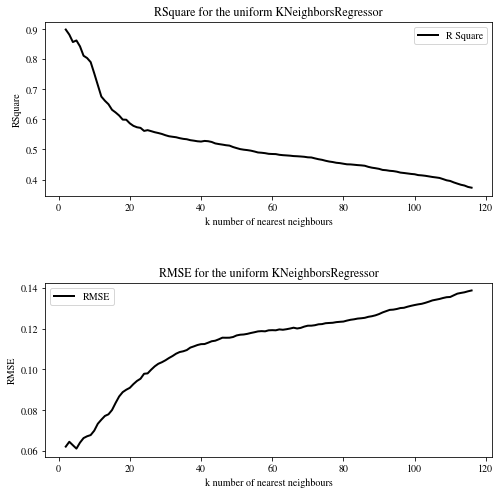

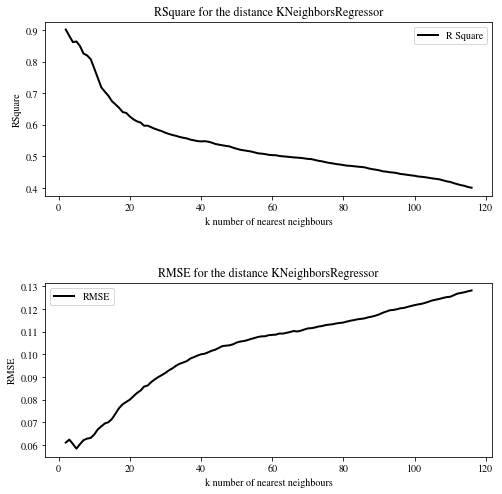

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
from pylab import rcParams

rcParams['figure.figsize'] = 14, 8
rcParams['font.size'] = 20
rcParams['figure.dpi'] = 350
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'

%matplotlib inline


for weight in ['uniform', 'distance']:
    rsquare_arr = []
    rmse_arr = []
    for k in range(2, len(y_test)):
        knn = neighbors.KNeighborsRegressor(n_neighbors=k,weights=weight)
        y_hat = knn.fit(X_train, y_train).predict(X_test)
        rsquare, rmse = calculate_regression_goodness_of_fit(y_test, y_hat)
        rmse_arr.append(rmse)
        rsquare_arr.append(rsquare)
    plot_k_accuracy(rsquare_arr, rmse_arr, y_test, weight)

A visual examination of the plotted R-squared values for both Uniform and Distance weighting does not show any variation between them. We also see no variation between the Uniform and Distance weighted plots for RMSE.

We see that the model had the best fit when k was equal to 2. As k increased the variation explained by the model decreased.

A similar effect is happening in the RMSE plots. We can see when k is equal to 2 the model fits the training data the well. As k increases the model's predictive accuracy decreases.

However, when k is small the model is more greatly affected by noise which devalues the accuracy of the model. Therefore, we must take a slightly bigger value than 2. From the plot, we can see there is a slight upswing called the 'elbow curve' in the R-squared when k equals 5. This would be a more appropriate k value for use in the model.

From this, we can conclude that a k equaling 5 is the best parameter for our regression model.

Now that we have determined our parameters, we can start altering the feature inputs. The following script increases the number of predictor variables, fits model, and calculates the R-squared value.

In [14]:
for i in range(2, len(oecd_df.columns)):
    X_train, X_test, y_train, y_test = train_test_split(oecd_df.iloc[:,1:i], oecd_df['Life Ladder (between 0 and 10)'], random_state=42, test_size=0.3)

    knn = neighbors.KNeighborsRegressor(n_neighbors=5,weights='distance')
    model = knn.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    r_squ, rmse = calculate_regression_goodness_of_fit(y_test, y_hat)
    print("Model with", i, "\tvariables  -  R_squared:", r_squ, "\t|\tRMSE:", rmse)

Model with 2 	variables  -  R_squared: 0.8530364758690245 	|	RMSE: 0.185915235266772
Model with 3 	variables  -  R_squared: 0.7761842989306346 	|	RMSE: 0.13062163876281077
Model with 4 	variables  -  R_squared: 0.7979706011231285 	|	RMSE: 0.09395615346510702
Model with 5 	variables  -  R_squared: 0.8291671757766829 	|	RMSE: 0.08882076104769492
Model with 6 	variables  -  R_squared: 0.8258209186638632 	|	RMSE: 0.09077645330741076
Model with 7 	variables  -  R_squared: 0.8401721335665471 	|	RMSE: 0.07932925834899267
Model with 8 	variables  -  R_squared: 0.8425114998262274 	|	RMSE: 0.08210659087362258
Model with 9 	variables  -  R_squared: 0.8756403953260782 	|	RMSE: 0.07825989903856365
Model with 10 	variables  -  R_squared: 0.8338265949628365 	|	RMSE: 0.08083670609434557
Model with 11 	variables  -  R_squared: 0.8465235377291929 	|	RMSE: 0.07301299776238171
Model with 12 	variables  -  R_squared: 0.8405229162657081 	|	RMSE: 0.0695364190587028
Model with 13 	variables  -  R_squared: 0.8

As we can see from the output above, a model with the first 17 predictor variables fits the data very well as it accounts for 88% of the variation in the target variable. The RMSE number is 0.0597 meaning that the residuals are not very spread out around the model.

#### Final Model
After a fair amount of experimentation, the following model has been constructed as it represents the most reliable predictor for happiness.

The model we have selected will be a kNN regression model that will look at the 5 closest neighbors with a distance weighting. There will be 17 predictor variables used to predict our target variable 'Life Ladder'

The model will be trained off a 70/30 train-test split of the OECD dataset.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(oecd_df.iloc[:,1:17], oecd_df['Life Ladder (between 0 and 10)'], random_state=42, test_size=0.3)

knn = neighbors.KNeighborsRegressor(n_neighbors=5,weights='distance')
model = knn.fit(X_train, y_train)
y_hat = model.predict(X_test)
r_squ, rmse = calculate_regression_goodness_of_fit(y_test, y_hat)

print("R_squared:", r_squ, "\t|\tRMSE:", rmse)

R_squared: 0.881084730957643 	|	RMSE: 0.05920424291207243


From the R-squared and RMSE output produced by the model above we can be very confident that this model will predict accurately new data it has not seen before.

I would not recommend that this model can be used to predict 'Life Ladder' values outside the boundaries of the trained data.